In [74]:
from matplotlib import cm, colors, pyplot as plt
import metaworld
import torch
from torch import nn
import copy
import ray
import numpy as np
import seaborn as sns

from nupic.embodied.utils.garage_utils import create_policy_net
from nupic.embodied.multitask.samplers.gpu_sampler import SamplerEvalOnly
from nupic.embodied.multitask.hooks.sparse_viz import (
    AverageSegmentActivationsHook,
    HiddenActivationsPercentOnHook,
    CombinedSparseVizHook
)

from nupic.research.frameworks.dendrites import AbsoluteMaxGatingDendriticLayer
from garage.experiment.task_sampler import MetaWorldTaskSampler

from nupic.embodied.utils.parser_utils import merge_args
sys.path.append("/Users/lsouza/nta/nupic.embodied/projects/multitask")
from args_parser import create_exp_parser
from experiments import CONFIGS

import numpy
import torch

from scipy.spatial.distance import cosine


# MLP-Dendrites Comparison

In [75]:
class HiddenActivationsPercentOnHookMLP(HiddenActivationsPercentOnHook):
    def attach(self, network):
        network.module.mean_log_std._layers[1].register_forward_hook(self.activation_hook_fn)     

def get_updated_policy(policy, hook):
    with torch.no_grad():
        updated_policy = copy.deepcopy(policy)
    updated_policy.eval()
    hook(updated_policy)
    return updated_policy

def init_experiment(state_path, config, mlp=False, average_hook=False):
    mt_env = metaworld.MT10(seed=42)
    train_task_sampler = MetaWorldTaskSampler(
        mt_env, "train", add_env_onehot=True
    )
    mt_train_envs = train_task_sampler.sample(10)
    env = mt_train_envs[0]()

    exp_parser = create_exp_parser()
    trainer_args = merge_args(exp_parser.parse_dict(CONFIGS[config]))

    env = mt_train_envs[0]()
    policy = create_policy_net(env_spec=env.spec, net_params=trainer_args)

    if state_path is not None:
        experiment_state = torch.load(state_path, map_location=torch.device('cpu'))
        policy.load_state_dict(experiment_state["algorithm"]["policy"])

    if mlp:
        print("Using MLP network")
        hook = HiddenActivationsPercentOnHookMLP
    elif average_hook:
        hook =AverageSegmentActivationsHook
    else:
        hook = HiddenActivationsPercentOnHook

    net = get_updated_policy(policy, hook)

    sampler = SamplerEvalOnly(
        agent=net,
        envs=mt_train_envs,
        max_episode_length=env.spec.max_episode_length,
        cpus_per_worker=0.5,
        gpus_per_worker=0,
        workers_per_env=1,
        seed=42,
    )

    return net, sampler

def collect_data(net, sampler):

    samples, hook_data = sampler.obtain_exact_episodes(
        n_eps_per_worker=1,
        agent_update=net,
        collect_hook_data=True,
    )

    data = next(iter(hook_data.values()))

    return data

def get_distances(data):
    distances = np.zeros((10,10))
    for i in range(len(data)):
        for j in range(len(data)):
            average_acts_i = data[i].mean(dim=0)
            average_acts_j = data[j].mean(dim=0)
            distances[i][j] = cosine(average_acts_i, average_acts_j)

    return distances

def calculate_avg_distances(data, num_samples=40):
    distances_same_task = []
    distances_other_task = []
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                distances_per_type = distances_same_task
            else:
                distances_per_type = distances_other_task
            acts_i = data[i]
            acts_j = data[j]
            for x in range(num_samples):# range(acts_i.shape[0]):
                for y in range(num_samples): # range (acts_j.shape[0]):
                    distances_per_type.append(cosine(acts_i[x, :], acts_j[y, :]))
    print("\nDistance same task: {:.4f}, across tasks: {:.4f}\n".format(
        np.mean(distances_same_task), np.mean(distances_other_task)
    ))          

def report(state_path, config, mlp=False, num_samples=40, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = None
    # distances = get_distances(data)
    # calculate_avg_distances(data, num_samples=num_samples)
    # sns.heatmap(distances)
    return net, sampler, data, distances

def get_network(state_path, config, mlp=False, num_samples=40, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    return net, sampler


In [76]:
state_path =  None
config = "no_overlap_10d_abs_max_signed"
net, sampler = get_network(state_path, config, mlp=False, average_hook=True)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [79]:
dendrite_layers = []
for name, layer in net.named_modules():
    if isinstance(layer, nn.Sequential) and "dendrite" in name:
        dendrite_layers.append(layer[0])
dendrite_layers

[AbsoluteMaxGatingDendriticLayer(
   sparsity=0.9
   (module): Linear(in_features=1950, out_features=1950, bias=True)
   (segments): DendriteSegments(num_units=1950, num_segments=10, dim_context=10, sparsity=0.0, bias=False)
   (dendritic_absolute_max_gate): DendriticAbsoluteMaxGate1d()
 )]

In [69]:
net.module.mean_log_std.dendritic_module.layers[1].dendrite[0] = layer
hook =AverageSegmentActivationsHook
net = get_updated_policy(net, hook)


In [79]:
net

GaussianDendriticMLPPolicy(
  (module): GaussianTwoHeadedDendriticMLPModule(
    (mean_log_std): CustomDendriticMLP(
      (preprocess_module): Sequential(
        (linear_layer): SparseWeights(
          sparsity=0.1
          (module): Linear(in_features=10, out_features=10, bias=True)
        )
        (nonlinearity): ReLU()
      )
      (dendritic_module): ModularDendriticMLP(
        (layers): ModuleList(
          (0): SequentialBlock(
            (ff): SequentialBlock(
              (0): FFLayer(
                sparsity=0.1
                (module): Linear(in_features=39, out_features=1950, bias=True)
              )
              (1): KWinners(n=1950, percent_on=0.25, boost_strength=0.0, boost_strength_factor=0.0, k_inference_factor=1.0, duty_cycle_period=1000, break_ties=False)
            )
          )
          (1): SequentialBlock(
            (dendrite): SequentialBlock(
              (0): GatingDendriticLayer(
                sparsity=0.9
                (module): Linea

In [75]:
layer.segments

DendriteSegments(num_units=1950, num_segments=10, dim_context=10, sparsity=0.0, bias=False)

In [102]:
??torch.randn

Docstring:
randn(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with random numbers from a normal distribution
with mean `0` and variance `1` (also called the standard normal
distribution).

.. math::
    \text{out}_{i} \sim \mathcal{N}(0, 1)

The shape of the tensor is defined by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device o

In [155]:
??torch.randn
# torch.randn(10)

Docstring:
randn(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with random numbers from a normal distribution
with mean `0` and variance `1` (also called the standard normal
distribution).

.. math::
    \text{out}_{i} \sim \mathcal{N}(0, 1)

The shape of the tensor is defined by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device o

In [209]:
linear = nn.Linear(6,6)
data = {}
for idx in range(6):
    activations = linear(torch.randn(6))
    data[idx] = activations.data
data

{0: tensor([ 0.4643, -0.2748,  0.1954,  0.5274,  0.1641, -0.3977]),
 1: tensor([ 0.7516,  0.4557,  0.2300, -0.8145,  0.6883, -0.3831]),
 2: tensor([ 0.1847, -0.3721,  0.9255,  0.0292,  1.2238, -0.4867]),
 3: tensor([-0.3135, -0.0603, -0.3473,  1.3045,  0.3024, -0.4117]),
 4: tensor([ 1.3615,  0.5777,  0.1970, -1.0123,  0.7672, -0.2796]),
 5: tensor([-0.0015, -0.1195,  0.1020,  0.5896, -0.1325, -0.1278])}

In [212]:
??layer.segments

Signature:      layer.segments(*input, **kwargs)
Type:           DendriteSegments
String form:    DendriteSegments(num_units=1950, num_segments=10, dim_context=10, sparsity=0.0, bias=False)
File:           ~/nta/nupic.research/nupic/research/frameworks/dendrites/modules/dendrite_segments.py
Source:        
class DendriteSegments(torch.nn.Module, HasRezeroWeights):
    """
    This implements dendrite segments over a set of units. Each unit has a set of
    segments modeled by a linear transformation from a context vector to output value
    for each segment.
    """

    def __init__(self, num_units, num_segments, dim_context, sparsity, bias=None):
        """
        :param num_units: number of units i.e. neurons;
                          each unit will have it's own set of dendrite segments
        :param dim_context: length of the context vector;
                            the same context will be applied to each segment
        :param num_segments: number of dendrite segments per

In [26]:
layer.module.weight.data = torch.randn(layer.module.weight.data.size())

['T_destination',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'apply_dendrites',
 'bfloat16',
 'bias',
 'buffers'

In [44]:
# layer.segments.weights.shape
ts = []
for _ in range(layer.segments.weights.shape[-1]):
    ts.append(torch.rand(layer.segments.weights.shape[:-1]).unsqueeze(dim=2))
ts = torch.cat(ts, dim=2)
layer.segments.weights.data = ts

In [38]:
ts[0].shape

torch.Size([2000, 10])

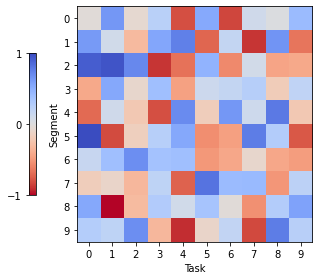

In [123]:
layer = AbsoluteMaxGatingDendriticLayer(
    module=nn.Linear(39, 2000, bias=True),
    num_segments=10, 
    dim_context=10, 
    module_sparsity=0.35, 
    dendrite_sparsity=0.0,
)

# reinit weights
# ts = []
# for _ in range(layer.segments.weights.shape[1]):
#     shape = layer.segments.weights.shape
#     ts.append(torch.rand(shape[0], shape[-1]).unsqueeze(dim=1)/np.sqrt(2000))
# ts = torch.cat(ts, dim=1)
# layer.segments.weights.data = ts

seq = nn.Sequential(
    # nn.Linear(10,10, bias=False),
    # nn.ReLU(),
    layer.segments
)
data = {}
for idx in range(10):
    inp = torch.ones(10)*-.1
    inp[idx] = 1.
    activations = seq(inp[None])
    data[idx] = activations.data

unit = 0
num_segments = 10
# Have to transpose, as plot expects a matrix (segments, tasks)
avg_activations = torch.stack([
    data[task_id][:, unit, :].mean(dim=0)
    for task_id in sorted(data)
]).T.numpy()

# vmax = np.abs(avg_activations).max()
# vmin = -1.0 * vmax
vmax = np.max(avg_activations)
vmin = np.min(avg_activations)

ax = plt.gca()
ax.imshow(avg_activations, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
plt.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(-1, 1), cmap="coolwarm_r"),
    ax=ax, location="left",
    shrink=0.6, drawedges=False, ticks=[-1.0, 0.0, 1.0]
)

ax.set_xlabel("Task")
ax.set_ylabel("Segment")
ax.set_xticks(range(len(data)))
ax.set_yticks(range(num_segments))

plt.tight_layout()


In [127]:
(torch.rand(2,2) - 0.5) / np.sqrt(10)

tensor([[-0.0318, -0.1003],
        [-0.0181,  0.0620]])

In [65]:
# ??layer.segments.forward
layer.segments(torch.randn(1,10))


tensor([[[ 0.1264,  1.0620, -0.7137,  ...,  0.6889, -0.2694,  0.5498],
         [ 0.1935, -0.7520, -0.7123,  ..., -0.3537, -1.0808,  0.4446],
         [ 1.1262, -0.2385,  0.0051,  ...,  0.0158, -1.3237,  0.5701],
         ...,
         [ 0.4718,  0.7041,  0.0504,  ...,  0.7992,  1.0027, -0.3293],
         [-0.3765,  0.7851, -0.1224,  ..., -0.3764,  0.5318, -0.3241],
         [-0.0931, -0.0298,  0.7986,  ..., -1.4811,  0.2726,  1.0255]]],
       grad_fn=<ViewBackward>)

In [23]:
import nupic.research.frameworks.dendrites as dendrites

In [26]:
??dendrites.GatingDendriticLayer

Init signature: dendrites.GatingDendriticLayer(*args, **kwargs)
Docstring:     
Base class for all Dendritic Layer modules.

This combines a DendriteSegments module with a SparseLinear module.
The output from the dendrite segments (shape of num_units x num_segments)
is applied to the output of of the linear weights (shape of num_units).
Thus, each linear output unit gets modulated by a set of dendritic segments.
Source:        
class GatingDendriticLayer(DendriticLayerBase):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dendritic_gate = DendriticGate1d()

    def apply_dendrites(self, y, dendrite_activations):
        """Apply dendrites as a gating mechanism."""
        return self.dendritic_gate(y, dendrite_activations).values
File:           ~/nta/nupic.research/nupic/research/frameworks/dendrites/modules/dendritic_layers.py
Type:           ABCMeta
Subclasses:     


In [29]:
layer = dendrites.GatingDendriticLayer()

TypeError: __init__() missing 5 required positional arguments: 'module', 'num_segments', 'dim_context', 'module_sparsity', and 'dendrite_sparsity'

In [54]:
layer = dendrites.GatingDendriticLayer(
    nn.Linear(1950, 1950),
    num_segments=10,
    dim_context=10,
    module_sparsity=0.9,
    dendrite_sparsity=0.0
)

In [55]:
torch.sum(layer.module.weight != 0) / np.prod(layer.module.weight.shape)

tensor(0.1000)

In [51]:
layer.module.weight 

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0224,  0.0000],
        [-0.0138,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0160,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0197,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [53]:
layer2 = net.module.mean_log_std.dendritic_module.layers[1].dendrite[0]
torch.sum(layer2.module.weight != 0) / np.prod(layer2.module.weight.shape)

tensor(0.9000)

In [7]:

from nupic.research.frameworks.dendrites import DendriticGate1d

net.module.mean_log_std.dendritic_module.layers[1].dendrite[0].dendritic_absolute_max_gate = DendriticGate1d()


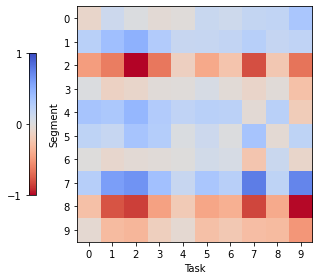

In [120]:
data = {}
for idx in range(10):
    net(torch.cat([torch.rand(39), torch.rand(10)])[None])
    activations = net.collect_hook_data()
    data[idx] = activations["AverageSegmentActivationsHook"]

unit = 0
num_segments = 10
# Have to transpose, as plot expects a matrix (segments, tasks)
avg_activations = torch.stack([
    data[task_id][:, unit, :].mean(dim=0)
    for task_id in sorted(data)
]).T.numpy()

vmax = np.abs(avg_activations).max()
vmin = -1.0 * vmax

ax = plt.gca()
ax.imshow(avg_activations, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
plt.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(-1, 1), cmap="coolwarm_r"),
    ax=ax, location="left",
    shrink=0.6, drawedges=False, ticks=[-1.0, 0.0, 1.0]
)

ax.set_xlabel("Task")
ax.set_ylabel("Segment")
ax.set_xticks(range(len(data)))
ax.set_yticks(range(num_segments))

plt.tight_layout()


In [101]:
# neurons, segments, tasks
for i in range(10):
    weights = net.module.mean_log_std.dendritic_module.layers[1].dendrite[0].segments.weights.data[:, :, i]
    print(i, torch.mean(weights))

0 tensor(-0.0011)
1 tensor(0.0015)
2 tensor(0.0022)
3 tensor(-0.0021)
4 tensor(0.0030)
5 tensor(0.0030)
6 tensor(-0.0023)
7 tensor(0.0010)
8 tensor(0.0014)
9 tensor(0.0010)


## Comparisons

In [ ]:
state_path = "/Users/lsouza/nta/results/no_overlap_10d_abs_max_signed_with_plots-idma329/experiment_state.p"
config = "no_overlap_10d_abs_max_signed"
report(state_path, config, mlp=False);

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))

Distance same task: 0.3773, across task: 0.9194



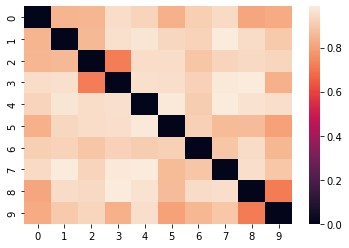

In [3]:
state_path = "/Users/lsouza/nta/results/no_overlap_10d_abs_max_signed_with_plots-idma329/experiment_state.p"
config = "no_overlap_10d_abs_max_signed"
report(state_path, config, mlp=False);

Using MLP network

Distance same task: 0.3455, across task: 0.9429



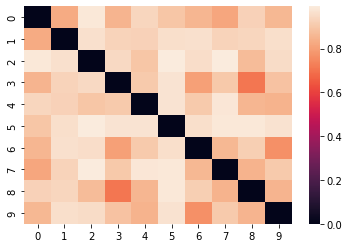

In [4]:
state_path_mlp = "/Users/lsouza/nta/results/new_metaworld_baseline-tvtt157/experiment_state.p"
config_mlp = "new_metaworld_baseline"
report(state_path_mlp, config_mlp, mlp=True);